In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
sns.set()

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns



from mlxtend.frequent_patterns import apriori, association_rules

# EDA

## Loading dataset 

#### Columns Description
- InvoiceNo
    - A 6-digit number uniquely assigned to each transaction. If the number is prefixed with 'c', it indicates a cancellation. (Nominal)
- StockCode: 
    - A unique identifier for each product sold by the retailer. (Nominal)
- Description 
    - The name or a brief description of the product. (Nominal)
- Quantity
    - The number of units of the product sold in each transaction. (Numeric)
- InvoiceDate
    - The date and time when the transaction was made. (Datetime)
- UnitPrice
    - The price per unit of the product in sterling. (Numeric)
- Country
    - The country where the customer resides. (Nominal)

In [2]:
df = pd.read_csv("online_retail.csv")

In [3]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

- **InvoiceNo**
    - By examining the first 5 rows initially, I can observe that this column contains numeric data. However, after checking the data type (dtype), it becomes apparent that this column has an object dtype because of the prefix 'c' present in some InvoiceNo entries, which indicates a cancellation of an order.
- **InvoiceDate** 
    - This column should be converted to datetime

#### Checking for missing values

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
round((df.isna().sum() / df.shape[0]) * 100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

- There are missing values in the columns Description (2%) and CustomerID (25%), which will need to be taken care of.
- Since this dataset is sourced from Kaggle, it is difficult to ask and receive feedback regarding the presence of NaN values in these columns.

In [6]:
df[df["Description"].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


In [7]:
df[df["Description"].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


- **CustomerID**:
    - Since the rows containing NaN values also hold valuable information in other columns, dropping these rows would be not a good idea.
- **Description**:
    - Although it contains NaN values, I believe that they can be filled using the StockCode column, which can help to find out the original description of the products. For example: It can be seen that the product with StockCode 22139 has NaN values in entities with indices 7203 and 622. However, in other entities with the same StockCode, the original description of the product can be observed, which can be used to fill those NaN values.

- **Mapping NaN Strategy**:
    - The rows containing NaN values, which cannot be filled (attributed to the dataset's origin from Kaggle, where additional information is unavailable), will be flagged as such for easier filtering. These rows are not dropped because they may still hold valuable information in other columns. Dropping them entirely would not be advisable.

- All rows that contain NaN values in the "CustomerID" column will be indicated in the mapping column.
- Now, I will fill NaN values in the "Description" column using the "StockCode" column.
    - First, I will use the StockCode to find the original names and fill in the NaN descriptions.
    - Second, if I cannot find the original descriptions for NaN values, I will fill them in as "Unknown".
    

In [8]:
df[df["StockCode"] == "22139"]["Description"].value_counts().index[0]

'RETROSPOT TEA SET CERAMIC 11 PC '

In [9]:
df[df["StockCode"] == "22139"]["Description"].unique()

array(['RETROSPOT TEA SET CERAMIC 11 PC ', nan, 'amazon'], dtype=object)

In [10]:
tmp_disc_list = []
disc_nan_idx = df[df["Description"].isna()].index
for idx_ in  tqdm(disc_nan_idx):
    stock_code = df["StockCode"][idx_]
    description = df[df["StockCode"] == stock_code]["Description"].value_counts()
    if len(description) != 0:
        description = df[df["StockCode"] == stock_code]["Description"].value_counts().index.tolist()[0]
        tmp_disc_list.append(description)
            
    else:
            tmp_disc_list.append("Unknown")
        # If the original description of the column is not found,to ensure consistency in data types within the column, NaN values will be replaced by 'unknown'.
        # =>As other columns contain valuable information that might be needed for other analyses, instead of dropping them, these NaN values will be filled with "Unknown".
df["Description"].loc[disc_nan_idx] = tmp_disc_list

100%|███████████████████████████████████████████████████████████████████████| 1454/1454 [00:55<00:00, 26.27it/s]
/var/folders/2m/qpsmbdfx5lgg4ps0zkpx_v3c0000gn/T/ipykernel_90265/1423106210.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

 

In [11]:
df[df["Description"].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


- All NaN values (1454) in the column Description have been filled.
- However, I will check if there are any NaN entities for which the original description was not found and instead were filled with "Unknown".

In [12]:
df[df["Description"] == "Unknown"]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1970,536545,21134,Unknown,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1987,536549,85226A,Unknown,1,12/1/2010 14:34,0.0,NaN,United Kingdom
1988,536550,85044,Unknown,1,12/1/2010 14:34,0.0,NaN,United Kingdom
2024,536552,20950,Unknown,1,12/1/2010 14:34,0.0,NaN,United Kingdom
2026,536554,84670,Unknown,23,12/1/2010 14:35,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
280754,561498,21610,Unknown,-14,7/27/2011 14:10,0.0,NaN,United Kingdom
281615,561555,37477B,Unknown,-11,7/28/2011 10:21,0.0,NaN,United Kingdom
281616,561557,37477C,Unknown,-31,7/28/2011 10:21,0.0,NaN,United Kingdom
346849,567207,35592T,Unknown,4,9/19/2011 11:01,0.0,NaN,United Kingdom


In [13]:
df[df["Description"] == "Unknown"]["UnitPrice"].unique()

array([0.])

- There are 112 entities for which the original description of the product was not found.
- I will double-check if there is indeed only one entity for each of these StockCodes.

In [14]:
s = { i : df[df["StockCode"] == i ].shape[0] for i in df[df["Description"] == "Unknown"]['StockCode']}
np.unique(list(s.values()), return_counts= True)

(array([1]), array([112]))

- 112 entities indeed do not have descriptions and have only one entity with the NaN description.
- Filling NaN values in string columns with "Unknown" is ok as it doesn't affect statistical properties. It's a placeholder for missing info. However, filling NaNs in numeric columns with 0 can introduce bias. This skews stats like mean and variance by inflating the frequency of 0 occurrences.

#### Drop duplicates

In [15]:
duplicates = df[df.duplicated()]
duplicates

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [16]:
df.drop_duplicates(inplace=True)

- There were 5268 duplicated rows within the dataset, which were dropped.

In [17]:
df.select_dtypes(include=['int', 'float'])

,Quantity,UnitPrice,CustomerID
0,6,2.55,17850.0
1,6,3.39,17850.0
2,8,2.75,17850.0
3,6,3.39,17850.0
4,6,3.39,17850.0
...,...,...,...
541904,12,0.85,12680.0
541905,6,2.10,12680.0
541906,4,4.15,12680.0
541907,4,4.15,12680.0


#### Descriptive Statistics

In [18]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,536641.000000,536641.000000,401604.000000
mean,9.620029,4.632656,15281.160818
std,219.130156,97.233118,1714.006089
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13939.000000
50%,3.000000,2.080000,15145.000000
75%,10.000000,4.130000,16784.000000
max,80995.000000,38970.000000,18287.000000


#### Numeric Data

- **Quantity:**
    - The mean is higher than the median, indicating that the quantity column is right-skewed.
    - The data range from -80995.00 to 80995.00 suggests the presence of negative values in the quantity column, possibly due to refunds.
    - Additionally, the high standard deviation of 219 indicates high variability in the quantity of bought products.
- **UnitPrice:**
    - Similar to the column quantity, the mean is higher than the median, indicating a right-skewed distribution.
    - The data range from -£11062 to £38970 suggests the presence of negative values in the prices column, possibly due to refunds.
    - The standard deviation reveals high variability in the prices of products.
    - Analysis of percentiles shows that most product prices are around £4. However, the maximum value indicates that some products have an extreme price of £38970.00.
- **CustomerID:**
    - The the minimum customer number is 12346.000000 and the maximum customer number is 18287.000000
    

- To ensure that negative values are indeed refund products, I am going to take a closer look at these entities.

In [19]:
df[df["Quantity"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


- We can assume that the negative values are indeed refund products, as explained in the metadata, an invoice prefixed with 'c' indicates a cancellation.
- It seems that there are descriptions that include not only product names but also other service related descriptions, which should be examined more closely. I believe filtering the dataframe where the description or StockCode is short would help to identify them.

### Outliers and Distribution Plots

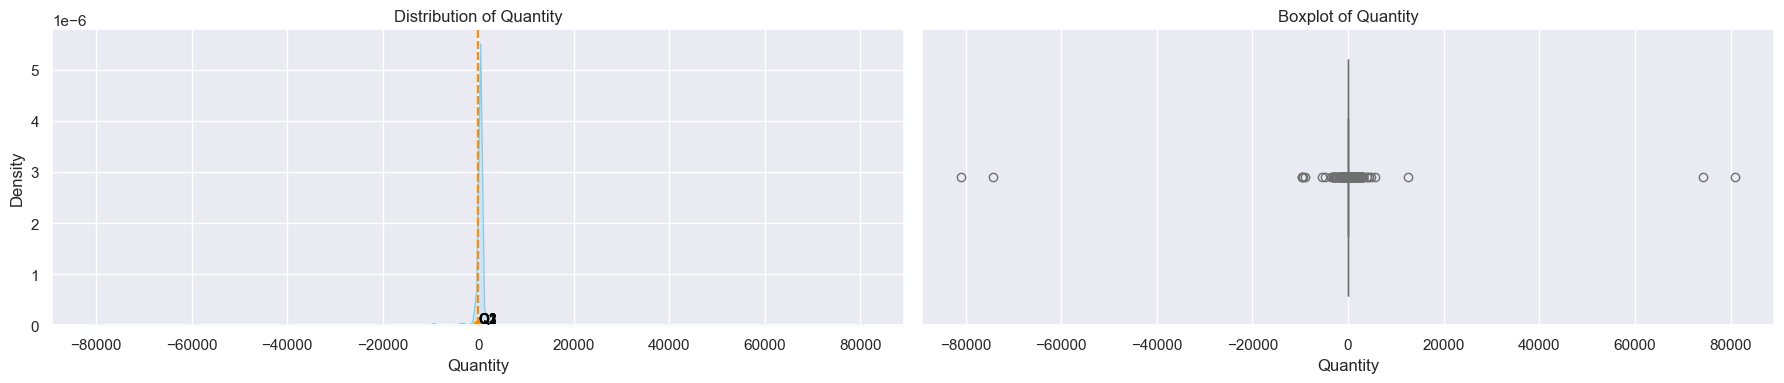

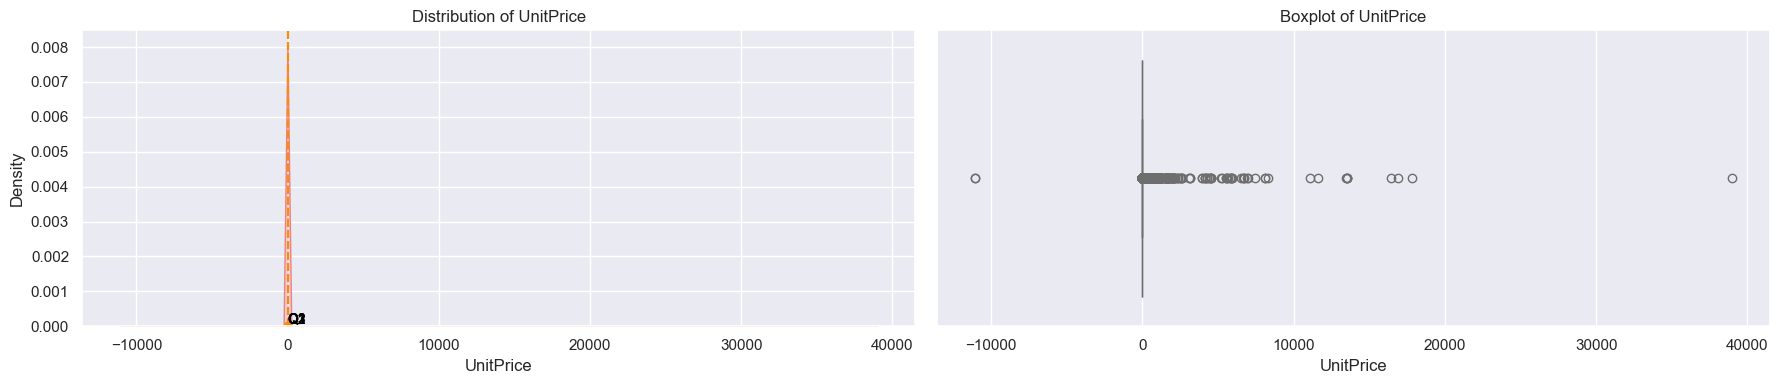

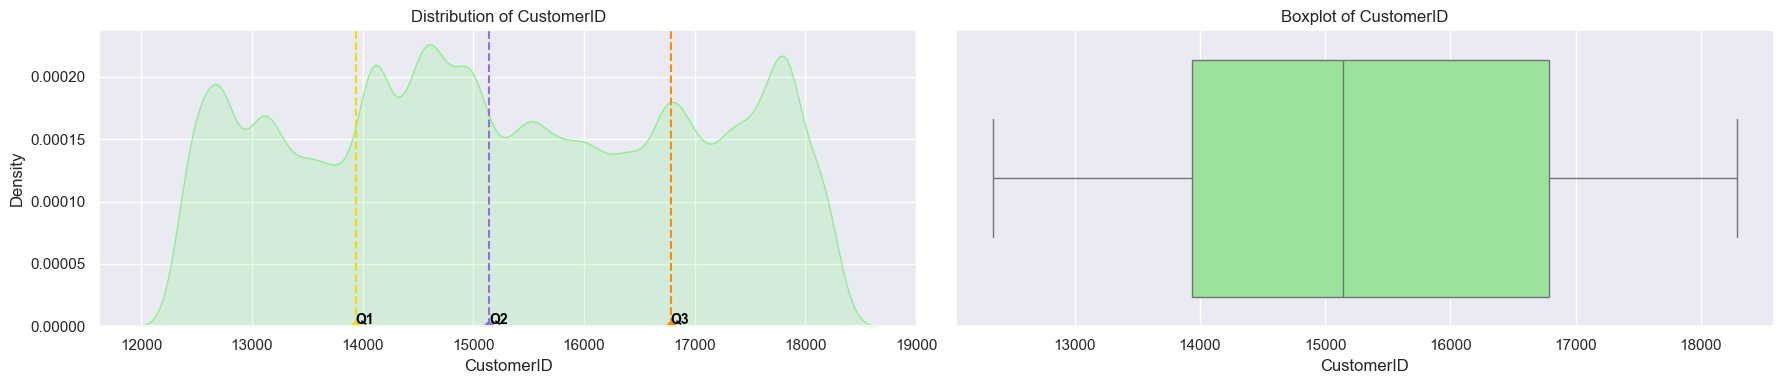

In [20]:
def plot_distributions(data, variables, colors):
    quartile_colors = ['#FFD700', '#9370DB', '#FF8C00']
    
    for i, (variable, color) in enumerate(zip(variables, colors)):
        
        fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        
        sns.kdeplot(data=data, x=variable, fill=True, ax=axes[0], color=color)
        # The beauty of kdeplot is that it automatically ignores NaN values when plotting.
        quartiles = data[variable].quantile([0.25, 0.5, 0.75])
        for j, q in enumerate([0.25, 0.5, 0.75]):
            quartile_label = f'Q{int(q * 4)}'
            line_pos = quartiles[q]
            axes[0].axvline(line_pos, linestyle='--', color=quartile_colors[j], label=quartile_label)
            axes[0].scatter([line_pos], [0], color=quartile_colors[j])
            axes[0].text(line_pos, 0, quartile_label, color="black", ha='left', va='bottom', fontsize='small', fontweight='bold')
        axes[0].set_title(f'Distribution of {variable}', fontsize=12)
        
        
        sns.boxplot(data=data, x=variable, ax=axes[1], color=color)
        axes[1].set_title(f'Boxplot of {variable}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightseagreen',
          'orchid', 'lightsalmon', 'thistle', 'khaki', 'orange', 'gold', 'thistle']

plot_distributions(df,variables = df.describe().columns,
                   colors = colors )

- Due to the presence of negative values, it is difficult to visualize the distribution of the columns Quantity and Unitprice.
- Therefore, for the purpose of plotting, I will filter out negative values and plot them separately

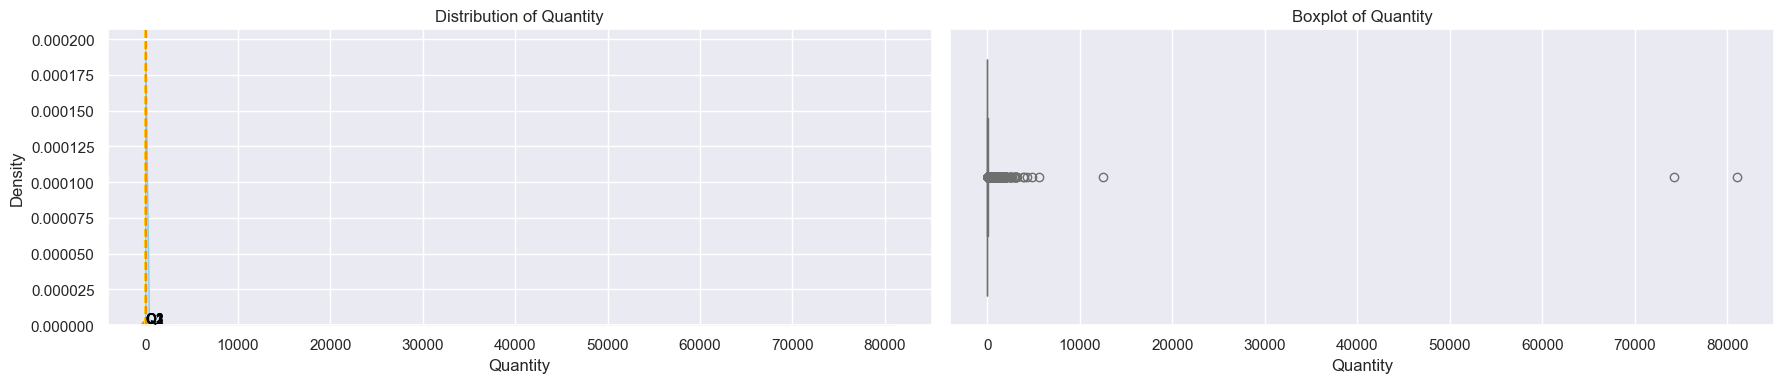

In [21]:
plot_distributions(df[df["Quantity"] > 0].drop(["UnitPrice","CustomerID"], axis = 1 ),
                   variables = ["Quantity"],
                   colors = colors )

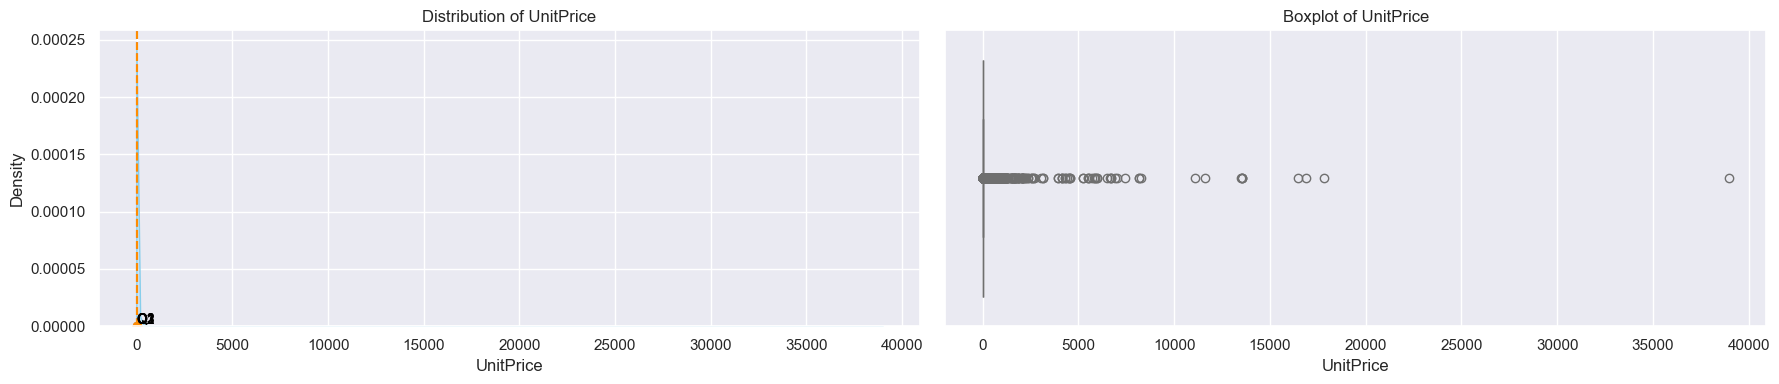

In [22]:
plot_distributions(df[df["UnitPrice"] > 0].drop(["Quantity","CustomerID"], axis = 1 ),
                   variables = ["UnitPrice"],
                   colors = colors )

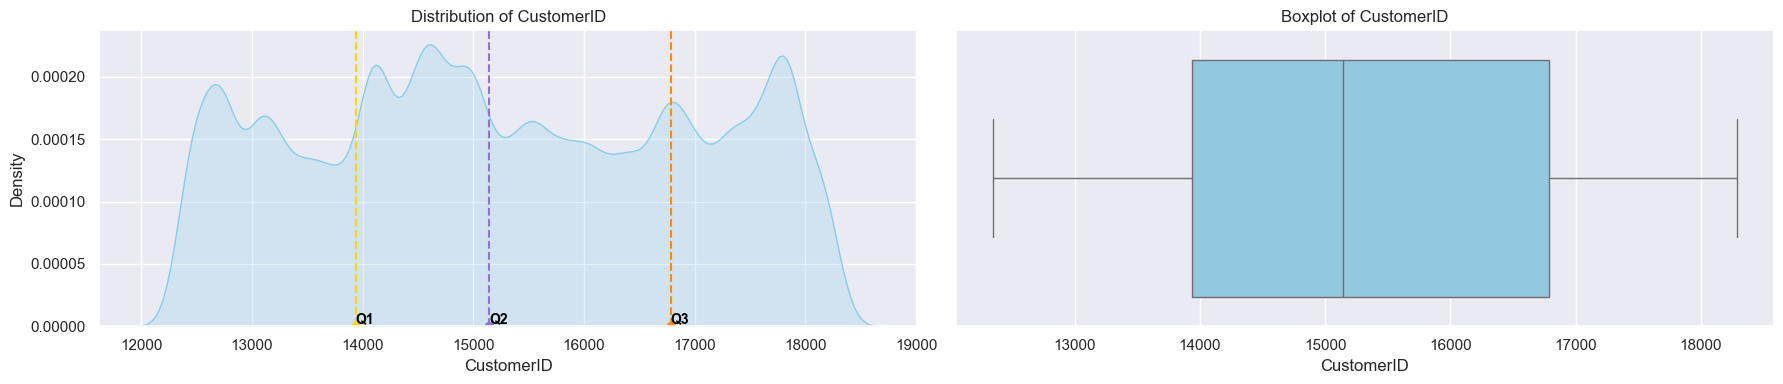

In [23]:
plot_distributions(df.drop(["Quantity","UnitPrice"], axis = 1 ),
                   variables = ["CustomerID"],
                   colors = colors )

- As expected, the quantity and unit price columns exhibit right-skewness and contain outliers.

#### Categorical Data

In [24]:
df.describe(include=['O'])

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,536641,536641,536641,536641,536641
unique,25900,4070,4224,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2301,2357,1114,490300


- **InvoiceNo**
    - There are 25900 unique invoices.
    - The invoice that bought the most products (1114) is 573585, which has the highest frequency of 1114.
- **StockCode**
    - This column contains a unique identifier for each product, indicating that 4070 unique products were sold.
    - The product with identifier 85123A was sold the most, with a frequency of 2301, indicating it was sold 2301 times.
- **Description**
    - There are 4224 unique product names.
    - Among all products, the WHITE HANGING HEART T-LIGHT HOLDER was purchased the most (2357 times).
- **Country**
    - There are 38 unique country names, with the majority of customers from the United Kingdom(490300).
    

In [25]:
for column_name in df.describe(include=['O']).columns:
    same_data_type = all(isinstance(value, type(df[column_name][0])) for value in df[column_name])
    if same_data_type:
        print(f"All values in column '{column_name}' have the same data type:", type(df[column_name][0]))
    else:
        print(f"Values in column '{column_name}' have different data types.")

All values in column 'InvoiceNo' have the same data type: <class 'str'>
All values in column 'StockCode' have the same data type: <class 'str'>
All values in column 'Description' have the same data type: <class 'str'>
All values in column 'InvoiceDate' have the same data type: <class 'str'>
All values in column 'Country' have the same data type: <class 'str'>


#### InvoiceNo

In [26]:
df["InvoiceNo"][0]

'536365'

In [27]:
len(df["InvoiceNo"][0])

6

- Sometimes checking the length of the data helps to identify redundant information.

In [28]:
df[df["InvoiceNo"].str.len()  > 6 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


-  As explained in the metadata, an invoice prefixed with 'c' indicates a cancellation.

In [29]:
df[df["InvoiceNo"].str.len()  > 7 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [30]:
df[df["InvoiceNo"].str.len()  < 6 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


- I will ensure that there are no invoices with prefixes other than 'c' using regular expressions.

In [31]:
pattern = r'^([a-zA-Z]+)'
prefix_check = df['InvoiceNo'].str.extract(pattern)

In [32]:
prefix_check[0].unique()

array([nan, 'C', 'A'], dtype=object)

- There are some invoices that have prefix A in it, which was not documented in meta data

In [33]:
prefix_check[prefix_check[0] == "A"]

,0
299982,A
299983,A
299984,A


In [34]:
df.loc[299982:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom
299985,563188,79160,HEART SHAPE WIRELESS DOORBELL,48,8/12/2011 15:00,1.69,15606.0,United Kingdom
299986,563188,22728,ALARM CLOCK BAKELIKE PINK,12,8/12/2011 15:00,3.75,15606.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


- According to the description column, invoices that have the prefix "A" in them are related to some kind of adjustment debt, specifically labeled as "Adjust bad debt."

- Another interesting thing is that there might be other data entities that should be given a closer look when analyzing the Description and StockCode columns.

#### StockCode

In [35]:
df["StockCode"].describe()

count     536641
unique      4070
top       85123A
freq        2301
Name: StockCode, dtype: object

In [36]:
df['StockCode'].str.len().describe()

count    536641.000000
mean          5.087034
std           0.360870
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max          12.000000
Name: StockCode, dtype: float64

- According to percentiles, median, and means, more than half of StockCodes consist of 5 letters. However, there are some that have only one letter, which should definitely be checked.

In [37]:
df[df['StockCode'].str.len() < 5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/1/2010 8:45,18.00,12583.0,France
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
386,536403,POST,POSTAGE,1,12/1/2010 11:27,15.00,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,12/1/2010 13:04,18.00,12662.0,Germany
1423,536540,C2,CARRIAGE,1,12/1/2010 14:05,50.00,14911.0,EIRE
...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,12/9/2011 10:26,1714.17,NaN,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541730,581570,POST,POSTAGE,1,12/9/2011 11:59,18.00,12662.0,Germany
541767,581574,POST,POSTAGE,2,12/9/2011 12:09,18.00,12526.0,Germany


- Filtering using the length of StockCode helped to identify data related to services, manuals, and discounts.

- I'm going to check if there are any data entities that were not mentioned in the data description provided by Kaggle while analyzing the Description column.

#### Description

In [38]:
df['Description'].str.len().describe()

count    536641.000000
mean         26.633891
std           5.460079
min           1.000000
25%          23.000000
50%          27.000000
75%          31.000000
max          35.000000
Name: Description, dtype: float64

- According to percentiles, median, and means, more than half of Descriptions consist of more than 20 letters. However, there are some descriptions that have a length of 1.

In [39]:
list(df["Description"].unique()[:50])

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 "POPPY'S PLAYHOUSE BEDROOM ",
 "POPPY'S PLAYHOUSE KITCHEN",
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'IVORY KNITTED MUG COSY ',
 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 'BOX OF VINTAGE JIGSAW BLOCKS ',
 'BOX OF VINTAGE ALPHABET BLOCKS',
 'HOME BUILDING BLOCK WORD',
 'LOVE BUILDING BLOCK WORD',
 'RECIPE BOX WITH METAL HEART',
 'DOORMAT NEW ENGLAND',
 'JAM MAKING SET WITH JARS',
 'RED COAT RACK PARIS FASHION',
 'YELLOW COAT RACK PARIS FASHION',
 'BLUE COAT RACK PARIS FASHION',
 'BATH BUILDING BLOCK WORD',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED ',
 'ALARM CLOCK BAKELIKE GREEN',
 'PANDA AND BUNNIES STICKER SHEET',
 'STARS GIFT TAPE ',
 'INFLATAB

- All product names are written in uppercase.
- Some product names have whitespace at the beginning and end of the word, which should be taken care of.

In [40]:
df["Description"] = df["Description"].astype(str).str.strip()

In [41]:
list(df["Description"].unique()[:50])

['WHITE HANGING HEART T-LIGHT HOLDER',
 'WHITE METAL LANTERN',
 'CREAM CUPID HEARTS COAT HANGER',
 'KNITTED UNION FLAG HOT WATER BOTTLE',
 'RED WOOLLY HOTTIE WHITE HEART.',
 'SET 7 BABUSHKA NESTING BOXES',
 'GLASS STAR FROSTED T-LIGHT HOLDER',
 'HAND WARMER UNION JACK',
 'HAND WARMER RED POLKA DOT',
 'ASSORTED COLOUR BIRD ORNAMENT',
 "POPPY'S PLAYHOUSE BEDROOM",
 "POPPY'S PLAYHOUSE KITCHEN",
 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 'IVORY KNITTED MUG COSY',
 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 'BOX OF VINTAGE JIGSAW BLOCKS',
 'BOX OF VINTAGE ALPHABET BLOCKS',
 'HOME BUILDING BLOCK WORD',
 'LOVE BUILDING BLOCK WORD',
 'RECIPE BOX WITH METAL HEART',
 'DOORMAT NEW ENGLAND',
 'JAM MAKING SET WITH JARS',
 'RED COAT RACK PARIS FASHION',
 'YELLOW COAT RACK PARIS FASHION',
 'BLUE COAT RACK PARIS FASHION',
 'BATH BUILDING BLOCK WORD',
 'ALARM CLOCK BAKELIKE PINK',
 'ALARM CLOCK BAKELIKE RED',
 'ALARM CLOCK BAKELIKE GREEN',
 'PANDA AND BUNNIES STICKER SHEET',
 'STARS GIFT TAPE',
 'INFLATABLE PO

In [42]:
list(df[df['Description'].str.len() < 5]["Description"].unique())

['?', 'MIA', 'FBA', 'ebay', 'test', '??', 'wet?', '???', 'wet', 'lost']

In [43]:
list(df[df['Description'].str.len() < 10]["Description"].unique())

['POSTAGE',
 'Discount',
 'CARRIAGE',
 'BINGO SET',
 'Unknown',
 'Manual',
 'SPACE OWL',
 'amazon',
 '?',
 'SOMBRERO',
 'check',
 'damages',
 'SAMPLES',
 'faulty',
 'Found',
 'found',
 'counted',
 'Dotcom',
 'showroom',
 'MIA',
 'broken',
 '?lost',
 'damages?',
 'cracked',
 'Damaged',
 'damaged',
 'DAMAGED',
 'Display',
 'Missing',
 'returned',
 'adjust',
 'crushed',
 'samples',
 'mailout',
 'wet/rusty',
 'smashed',
 'missing',
 'FOUND',
 'dotcom',
 'FBA',
 'ebay',
 '?display?',
 'sold as 1',
 '?missing',
 'Crushed',
 'test',
 '??',
 'Amazon',
 'found box',
 'Dagamed',
 'mouldy',
 'Breakages',
 '20713',
 'Damages',
 'CHECK',
 'missing?',
 'wet rusty',
 '???lost',
 'check?',
 'AMAZON',
 'wet?',
 'lost??',
 '???',
 'wet',
 'wet boxes',
 'mixed up',
 'lost']

In [44]:
list(df[df['Description'].str.len() < 15]["Description"].unique())

['POSTAGE',
 'Discount',
 'CHILLI LIGHTS',
 'PHOTO CUBE',
 'RETROSPOT LAMP',
 'DOORMAT HEARTS',
 'WRAP COWBOYS',
 'JUMBO BAG OWLS',
 'OWL DOORSTOP',
 'WICKER STAR',
 'FIRST AID TIN',
 'BUTTON BOX',
 'POLKADOT PEN',
 'CARRIAGE',
 'JUMBO BAG TOYS',
 'BINGO SET',
 'LOCAL CAFE MUG',
 'FUNKY DIVA PEN',
 'DOTCOM POSTAGE',
 'Unknown',
 'RETRO MOD TRAY',
 'Manual',
 'CUTE CATS TAPE',
 'GLAMOROUS  MUG',
 'SHOE SHINE BOX',
 'Bank Charges',
 'SPACE FROG',
 'SPACE OWL',
 'KEY FOB , SHED',
 'FROG CANDLE',
 'POTTERING MUG',
 'DOGGY RUBBER',
 'SKULLS TAPE',
 'PARTY BUNTING',
 'BLUE FLY SWAT',
 'RIBBONS PURSE',
 'amazon',
 'PINK DOG BOWL',
 '?',
 'SANDALWOOD FAN',
 'SOMBRERO',
 'RAIN PONCHO',
 'MIRROR CORNICE',
 'DAISY JOURNAL',
 'POSY CANDY BAG',
 'DAISY NOTEBOOK',
 'GOLD WASHBAG',
 'check',
 'WRAP FOLK ART',
 'damages',
 'SAMPLES',
 'AMAZON FEE',
 'PINK CAT BOWL',
 'faulty',
 'POMPOM CURTAIN',
 'Dotcom sales',
 'amazon sales',
 'PINK FLY SWAT',
 'TOYBOX  WRAP',
 'Found',
 'WRAP, CAROUSEL',
 'found',

In [45]:
df[(df['Description'].str.len() < 20)]["Description"].unique()
#df[(df['Description'].str.len() < 23)]["Description"].unique() Does not introduce any new inconsistent data.

array(['WHITE METAL LANTERN', 'DOORMAT NEW ENGLAND', 'STARS GIFT TAPE',
       'SPACEBOY LUNCH BOX', 'POSTAGE', 'SAVE THE PLANET MUG',
       'GIRLY PINK TOOL SET', 'PHOTO CLIP LINE', 'SKULL SHOULDER BAG',
       'BLUE OWL SOFT TOY', 'GLASS CLOCHE SMALL', 'Discount',
       'CHILLI LIGHTS', 'POLKADOT RAIN HAT', 'DELUXE SEWING KIT',
       'PHOTO CUBE', 'RETROSPOT LAMP', 'TRAVEL SEWING KIT',
       'RED RETROSPOT MUG', 'DOORMAT FAIRY CAKE', 'PHOTO FRAME CORNICE',
       'PICTURE DOMINOES', 'MIRRORED DISCO BALL', 'DOORMAT TOPIARY',
       'BATHROOM METAL SIGN', 'KITCHEN METAL SIGN', 'TOILET METAL SIGN',
       'APPLE BATH SPONGE', 'LUNCH BAG WOODLAND', 'GUMBALL COAT RACK',
       'LUNCH BAG CARS BLUE', 'DOORMAT HEARTS', 'CARD CIRCUS PARADE',
       'WRAP COWBOYS', 'FLOWERS  STICKERS', 'JUMBO BAG OWLS',
       'OWL DOORSTOP', 'BLUE POLKADOT PLATE', 'RED RETROSPOT PLATE',
       'RED RETROSPOT TAPE', 'SOLDIERS EGG CUP', 'WICKER WREATH SMALL',
       'WICKER STAR', 'VINTAGE SNAP CARDS', 'UR

- **Description** column contains entities related not only to services, manuals, and discounts but also to the following:
  - "Had been put aside", "Amazon Adjustment,?display?" ,"???missing", "rusty throw away", "damaged products", "lost products and so on".
  - Also, some description data should be normalized for consistency: 
      - For example: 
        - "had been put aside" should be changed to "Had been put aside".
        - "amazon" to "Amazon"
- First of all, these entities should be identified. Therefore, there is a need to create logic to do so.

In [46]:
unique = df[(df['Description'].str.len() < 20)]["Description"].unique()

In [47]:
filtered_descriptions =  df[(df['Description'].str.len() < 20)]["Description"].unique()
idx_uppercase = np.where([np.char.isupper(val) for val in unique])

In [48]:
'AMAZON','AMAZON FEE','FBA','DAMAGED','FOUND','WET/MOULDY','CHECK'

('AMAZON', 'AMAZON FEE', 'FBA', 'DAMAGED', 'FOUND', 'WET/MOULDY', 'CHECK')

In [49]:
filtered_uppercase_descriptions = df[(df['Description'].str.len() < 20)]["Description"].unique()[idx_uppercase]

In [50]:
filtered_uppercase_descriptions

array(['WHITE METAL LANTERN', 'DOORMAT NEW ENGLAND', 'STARS GIFT TAPE',
       'SPACEBOY LUNCH BOX', 'POSTAGE', 'SAVE THE PLANET MUG',
       'GIRLY PINK TOOL SET', 'PHOTO CLIP LINE', 'SKULL SHOULDER BAG',
       'BLUE OWL SOFT TOY', 'GLASS CLOCHE SMALL', 'CHILLI LIGHTS',
       'POLKADOT RAIN HAT', 'DELUXE SEWING KIT', 'PHOTO CUBE',
       'RETROSPOT LAMP', 'TRAVEL SEWING KIT', 'RED RETROSPOT MUG',
       'DOORMAT FAIRY CAKE', 'PHOTO FRAME CORNICE', 'PICTURE DOMINOES',
       'MIRRORED DISCO BALL', 'DOORMAT TOPIARY', 'BATHROOM METAL SIGN',
       'KITCHEN METAL SIGN', 'TOILET METAL SIGN', 'APPLE BATH SPONGE',
       'LUNCH BAG WOODLAND', 'GUMBALL COAT RACK', 'LUNCH BAG CARS BLUE',
       'DOORMAT HEARTS', 'CARD CIRCUS PARADE', 'WRAP COWBOYS',
       'FLOWERS  STICKERS', 'JUMBO BAG OWLS', 'OWL DOORSTOP',
       'BLUE POLKADOT PLATE', 'RED RETROSPOT PLATE', 'RED RETROSPOT TAPE',
       'SOLDIERS EGG CUP', 'WICKER WREATH SMALL', 'WICKER STAR',
       'VINTAGE SNAP CARDS', 'URBAN BLACK RI

In [51]:
inconsistent_data = list(df[(df['Description'].str.len() < 20) & (df['Description'].isin(filtered_uppercase_descriptions) != True)]['Description'])
inconsistent_data.append("DOTCOM POSTAGE")

In [52]:
np.unique(inconsistent_data, return_counts=True)

(array(['20713', '?', '? sold as sets?', '??', '?? missing', '???',
        '????damages????', '????missing', '???lost', '???missing',
        '?display?', '?lost', '?missing', '?sold as sets?',
        'Adjust bad debt', 'Adjustment', 'Amazon', 'Amazon Adjustment',
        'Amazon sold sets', 'Bank Charges', 'Breakages', 'CRUK Commission',
        'Crushed', 'DOTCOM POSTAGE', 'Dagamed', 'Damaged', 'Damages',
        'Damages/samples', 'Discount', 'Display', 'Dotcom', 'Dotcom sales',
        'Dotcom set', "Dotcom sold in 6's", 'Found', 'Found by jackie',
        'Found in w/hse', 'Given away', 'Had been put aside.',
        'John Lewis', 'Manual', 'Marked as 23343', 'Missing',
        'Next Day Carriage', 'OOPS ! adjustment', 'Sale error',
        'Show Samples', 'Sold as 1 on dotcom', 'Thrown away-rusty',
        'Thrown away.', 'Unknown', 'Water damaged', 'adjust', 'adjustment',
        'amazon', 'amazon adjust', 'amazon sales', 'barcode problem',
        'broken', 'came coded as 207

- As it can be seen, there are some inconsistent entities within the dataset that should be normalized.
- Also, new flagging column should be created because of the following:

   - Preservation of Data Integrity
   - Traceability and Transparency
   - Data Analysis Flexibility
   - Audit Trail
   - Future Data Improvement Efforts: 

In [53]:
normalization_dict = {
    'amazon': 'Amazon',
    'check': 'Check',
    'damages': 'Damages',
    'faulty': 'Faulty',
    'Dotcom sales': 'Dotcom Sales',
    'amazon sales': 'Amazon Sales',
    'found': 'Found',
    'counted': 'Counted',
    'Dotcom': 'Dotcom',
    'label mix up': 'Label Mix Up',
    'samples/damages': 'Samples/Damages',
    'thrown away': 'Thrown Away',
    'showroom': 'Showroom',
    'Dotcom set': 'Dotcom Set',
    'Amazon sold sets': 'Amazon Sold Sets',
    'dotcom sold sets': 'Dotcom Sold Sets',
    'wrongly sold sets': 'Wrongly Sold Sets',
    '? sold as sets?': 'Sold As Sets',
    '?sold as sets?': 'Sold As Sets',
    'Thrown away.': 'Thrown Away',
    'damages/display': 'Damages/Display',
    'damaged stock': 'Damaged Stock',
    'broken': 'Broken',
    'throw away': 'Thrown Away',
    'wrong barcode': 'Wrong Barcode',
    'barcode problem': 'Barcode Problem',
    '?lost': 'Lost',
    'damages?': 'Damaged',
    "Dotcom sold in 6's": 'Dotcom Sold in Sets',
    'sold in set?': 'Sold in Set',
    'cracked': 'Cracked',
    'sold as 22467': 'Sold as 22467',
    'damaged': 'Damaged',
    'adjustment': 'Adjustment',
    'returned': 'Returned',
    'wrong code?': 'Wrong Code',
    'wrong code': 'Wrong Code',
    'adjust': 'Adjustment',
    'crushed': 'Crushed',
    'samples': 'Samples',
    'mailout ': 'Mailout',
    'mailout': 'Mailout',
    'Thrown away-rusty': 'Thrown Away - Rusty',
    'wet/rusty': 'Wet/Rusty',
    'damages/dotcom?': 'Damages/Dotcom',
    'on cargo order': 'On Cargo Order',
    'smashed': 'Smashed',
    'wet damaged': 'Water Damaged',
    'Water damaged': 'Water Damaged',
    'missing': 'Missing',
    'water damage': 'Water Damaged',
    'Show Samples': 'Show Samples',
    'mix up with c': 'Mix Up with C',
    'mouldy, unsaleable.': 'Mouldy/Unsaleable',
    'came coded as 20713': 'Came Coded as 20713',
    'dotcom': 'Dotcom',
    'ebay': 'Ebay',
    'Damages/samples': 'Damages/Samples',
    'Sold as 1 on dotcom': 'Sold as 1 on Dotcom',
    'Adjust bad debt': 'Adjust Bad Debt',
    'code mix up? 84930': 'Code Mix Up 84930',
    '?display?': 'Display',
    'sold as 1': 'Sold as 1',
    '?missing': 'Missing',
    'crushed ctn': 'Crushed Ctn',
    'test': 'Test',
    'temp adjustment': 'Temporary Adjustment',
    'taig adjust': 'Taig Adjust',
    'Amazon': 'Amazon',
    'found box': 'Found Box',
    'OOPS ! adjustment': 'Adjustment',
    'Found in w/hse': 'Found in Warehouse',
    'website fixed': 'Website Fixed',
    'Dagamed': 'Damaged',
    'michel oops': 'Michel Oops',
    'wrongly coded 20713': 'Wrongly Coded 20713',
    'wrongly coded-23343': 'Wrongly Coded 23343',
    'stock check': 'Stock Check',
    'crushed boxes': 'Crushed Boxes',
    "can't find": "Can not Find",
    'mouldy': 'Mouldy',
    'Had been put aside.': 'Had Been Put Aside',
    'Sale error': 'Sale Error',
    'Amazon Adjustment': 'Amazon Adjustment',
    're-adjustment': 'Re-Adjustment',
    'Breakages': 'Breakages',
    'wrongly coded 23343': 'Wrongly Coded 23343',
    'Found by jackie': 'Found by Jackie',
    'wrongly marked': 'Wrongly Marked',
    'dotcom sales': 'Dotcom Sales',
    'had been put aside': 'Had Been Put Aside',
    'damages wax': 'Damaged Wax',
    'water damaged': 'Water Damaged',
    'missing?': 'Missing',
    'wet rusty': 'Wet Rusty',
    'amazon adjust': 'Amazon Adjustment',
    'dotcomstock': 'Dotcom Stock',
    'dotcom adjust': 'Dotcom Adjust',
    'rusty thrown away': 'Rusty Thrown Away',
    'rusty throw away': 'Rusty Thrown Away',
    'check?': 'Check',
    '?? missing': 'Missing',
    'wet pallet': 'Wet Pallet',
    '????missing': 'Missing',
    '???missing': 'Missing',
    'lost in space': 'Lost in Space',
    'wet?': 'Wet',
    'lost??': 'Lost',
    'wet': 'Wet',
    'wet boxes': 'Wet Boxes',
    '????damages????': 'Damages',
    'mixed up': 'Mixed Up',
    'lost': 'Lost',
    '???lost':'Lost',
}


1. Normalasing Columns Data
2. Flagging inconsistent Data

In [54]:
df["Description"].replace(normalization_dict, inplace=True) # Normalasing

In [55]:
flagging_data = {
    "?":1,
    "??":1,
    "???":1,
    "Unknown":1,
    "20713":1

}
df['InconsistentDescription'] = df['Description'].copy()
df['InconsistentDescription'] = df['InconsistentDescription'].map(flagging_data).fillna(0).astype(dtype= int) # Flagging Inconsistent Data

#### InvoiceDate

In [56]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format='%m/%d/%Y %H:%M')

In [57]:
weekday = [week_day.weekday() for week_day in df["InvoiceDate"]]

In [58]:
df['DayOfWeek'] = weekday
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year

In [59]:
day_of_week_distribution = df.groupby('DayOfWeek').size()
month_distribution = df.groupby('Month').size()
year_distribution = df.groupby('Year').size()

In [60]:
year_distribution

Year
2010     41981
2011    494660
dtype: int64

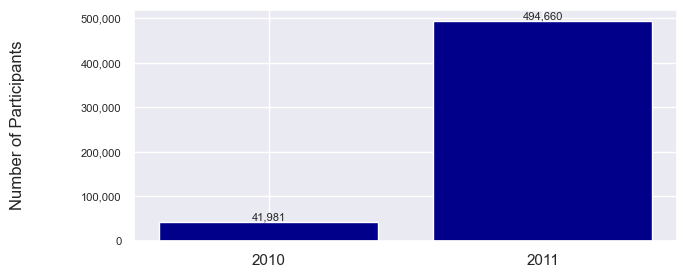

In [61]:

fig = plt.figure(figsize=(7, 3)) 

bars = plt.bar(x=year_distribution.index,
               height=year_distribution,
               color="darkblue")
plt.ylabel("Number of Participants", labelpad=40) 
plt.tick_params(axis="y", width=2, labelsize=8)


formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '{:,.0f}'.format(bar.get_height()), ha='center', va='bottom', fontsize=8)

plt.show()

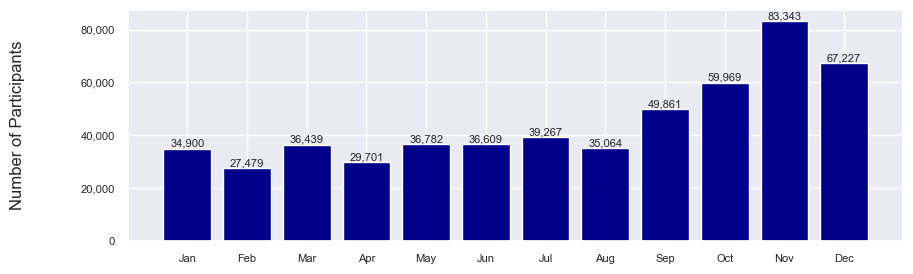

In [62]:
fig = plt.figure(figsize=(10, 3)) 

bars = plt.bar(x=month_distribution.index,
               height=month_distribution,
               color="darkblue")
plt.ylabel("Number of Participants", labelpad=40) 
plt.yticks(fontsize=8)


tick_positions = range(1, 13)
tick_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(tick_positions, tick_labels, fontsize=8)

formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '{:,.0f}'.format(bar.get_height()), ha='center', va='bottom', fontsize=8)

plt.show()


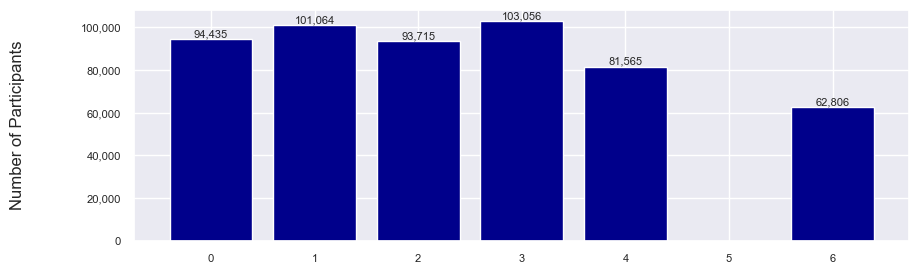

In [63]:
fig = plt.figure(figsize=(10, 3)) 

bars = plt.bar(x=day_of_week_distribution.index,
               height=day_of_week_distribution,
               color="darkblue")
plt.ylabel("Number of Participants", labelpad=40) 
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)

formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)


plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             '{:,.0f}'.format(bar.get_height()), ha='center', va='bottom', fontsize=8)

plt.show()


- The dataset has a strange inconsistency of not having data of transactions on Saturdays. The assumption is that it is possible that they do not operate on Saturdays. However, without direct access to the origin of the data source, it is difficult to check this assumption.

#### UnitPrice

In [64]:
df["UnitPrice"].describe()

count    536641.000000
mean          4.632656
std          97.233118
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

In [65]:
df[df["UnitPrice"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InconsistentDescription,DayOfWeek,Month,Year
299983,A563186,B,Adjust Bad Debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,0,4,8,2011
299984,A563187,B,Adjust Bad Debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,0,4,8,2011


In [66]:
df[df["Description"].isna() ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InconsistentDescription,DayOfWeek,Month,Year


- The negative prices are related to "Adjust Bad Debt"


#### Country

In [67]:
df["Country"].unique().tolist()

['United Kingdom',
 'France',
 'Australia',
 'Netherlands',
 'Germany',
 'Norway',
 'EIRE',
 'Switzerland',
 'Spain',
 'Poland',
 'Portugal',
 'Italy',
 'Belgium',
 'Lithuania',
 'Japan',
 'Iceland',
 'Channel Islands',
 'Denmark',
 'Cyprus',
 'Sweden',
 'Austria',
 'Israel',
 'Finland',
 'Bahrain',
 'Greece',
 'Hong Kong',
 'Singapore',
 'Lebanon',
 'United Arab Emirates',
 'Saudi Arabia',
 'Czech Republic',
 'Canada',
 'Unspecified',
 'Brazil',
 'USA',
 'European Community',
 'Malta',
 'RSA']

- There are some inconsistencies within the column.
    - "Ireland" country was written in Irish.
    - "USA" and "RSA" should be written fully because all other countries are written out in full. Therefore, "USA" should be changed to "United States" and "RSA" should be changed to "Republic of South Africa" respectively.
    - "European Community" is not a country but rather an economic and political union comprising several European countries. It's not typically listed alongside individual countries in such contexts.


In [68]:
mapping_country = {'EIRE': 'Ireland',
                   'USA':'United States',
                   'RSA': 'Republic of South Africa'}

In [69]:
df["Country"] = df["Country"].replace(mapping_country)
df["Country"].unique().tolist()

['United Kingdom',
 'France',
 'Australia',
 'Netherlands',
 'Germany',
 'Norway',
 'Ireland',
 'Switzerland',
 'Spain',
 'Poland',
 'Portugal',
 'Italy',
 'Belgium',
 'Lithuania',
 'Japan',
 'Iceland',
 'Channel Islands',
 'Denmark',
 'Cyprus',
 'Sweden',
 'Austria',
 'Israel',
 'Finland',
 'Bahrain',
 'Greece',
 'Hong Kong',
 'Singapore',
 'Lebanon',
 'United Arab Emirates',
 'Saudi Arabia',
 'Czech Republic',
 'Canada',
 'Unspecified',
 'Brazil',
 'United States',
 'European Community',
 'Malta',
 'Republic of South Africa']

In [70]:
country_stats = (df["Country"].value_counts() / df.shape[0] ) * 100

In [71]:
country_stats

Country
United Kingdom              91.364618
Germany                      1.766544
France                       1.591567
Ireland                      1.525042
Spain                        0.471078
Netherlands                  0.441822
Belgium                      0.385546
Switzerland                  0.371571
Portugal                     0.281380
Australia                    0.234421
Norway                       0.202370
Italy                        0.149634
Channel Islands              0.141063
Finland                      0.129509
Cyprus                       0.113856
Sweden                       0.085905
Unspecified                  0.082364
Austria                      0.074724
Denmark                      0.072488
Japan                        0.066711
Poland                       0.063543
Israel                       0.054785
United States                0.054226
Hong Kong                    0.052922
Singapore                    0.042673
Iceland                      0.033915
Cana

## Data Preprocessing

In [72]:
df_or = df.copy()

### First filtering: Getting rid of the data entities that have inconsistencies and data related to services

In [73]:
for incon_str in tqdm(inconsistent_data):
    df = df[df['Description'] != incon_str]

100%|███████████████████████████████████████████████████████████████████████| 1446/1446 [00:53<00:00, 27.15it/s]


### Second Filtering: Filtering based on the number of items in each "Busket/Invoice"

In [74]:
#df = pd.read_csv("cleaned.csv")

tmp = df[["InvoiceNo", "Description"]].groupby("InvoiceNo").count()
print(tmp.describe())

        Description
count  25154.000000
mean      21.260118
std       43.180741
min        1.000000
25%        2.000000
50%       11.000000
75%       24.000000
max     1113.000000


/var/folders/2m/qpsmbdfx5lgg4ps0zkpx_v3c0000gn/T/ipykernel_90265/214468246.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp)


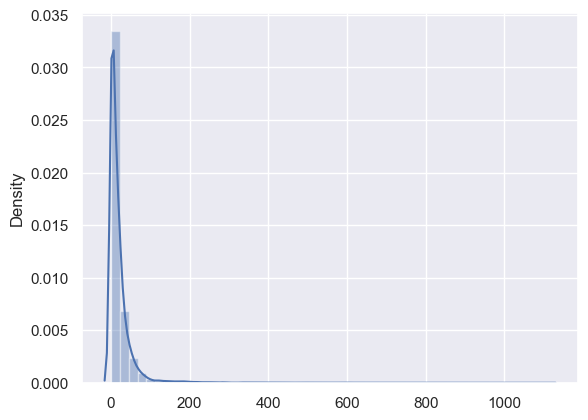

In [75]:
sns.distplot(tmp)
plt.show()

## Description of the data distribution
- According to the descriptive statistics and the distplot, it can be seen that the data is highly right-skewed. This indicates that only a few invoices have a high number of purchased items.
    - The range of the number of items in invoices is between 1 and 1,114.
    - 25th Percentile: 1 item per invoice 
    - 50th Percentile: 2 items per invoice
    - 75th Percentile: 10 items per invoice
    - Starting from the 76th percentile and up, some invoices contain between 23 and 1,114 items per invoice.
- For the Market Basket Analysis, it is important that each purchase contains several items in order to find meaningful relationships between the items.

### Reason and Decision for Data Filtering
##### We decided to concentrate on invoices/purchases that have a significant number of items for the following reasons:
- Computational resources that we have available for use (the main reason).
- We want to concentrate on the top 10% of invoices in terms of the number of items.


In [76]:
invoice_threshold = tmp['Description'].quantile(0.90)
print(f'Items per Invoice Threshold (90th percentile): {invoice_threshold}')

list_interest = tmp[tmp["Description"]>invoice_threshold].index
tmp = df[df["InvoiceNo"].isin(list_interest)]

Items per Invoice Threshold (90th percentile): 46.0


In [77]:
tmp

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InconsistentDescription,DayOfWeek,Month,Year
318,536401,22110,BIRD HOUSE HOT WATER BOTTLE,1,2010-12-01 11:21:00,2.55,15862.0,United Kingdom,0,2,12,2010
319,536401,22098,BOUDOIR SQUARE TISSUE BOX,1,2010-12-01 11:21:00,1.25,15862.0,United Kingdom,0,2,12,2010
320,536401,22100,SKULLS SQUARE TISSUE BOX,2,2010-12-01 11:21:00,1.25,15862.0,United Kingdom,0,2,12,2010
321,536401,22766,PHOTO FRAME CORNICE,1,2010-12-01 11:21:00,2.95,15862.0,United Kingdom,0,2,12,2010
322,536401,22451,SILK PURSE BABUSHKA RED,1,2010-12-01 11:21:00,3.35,15862.0,United Kingdom,0,2,12,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
541695,581538,20727,LUNCH BAG BLACK SKULL.,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom,0,4,12,2011
541696,581538,20725,LUNCH BAG RED RETROSPOT,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom,0,4,12,2011
541697,581538,21194,PINK HONEYCOMB PAPER FAN,1,2011-12-09 11:34:00,0.65,14446.0,United Kingdom,0,4,12,2011
541698,581538,35004B,SET OF 3 BLACK FLYING DUCKS,1,2011-12-09 11:34:00,5.45,14446.0,United Kingdom,0,4,12,2011


## Third Filtering Based on the number of items in each "Busket/Invoice"

In [78]:
print(len(df["Description"].unique()))
print(len(tmp["Description"].unique()))

4150
3778


- After the first filtering, the number of unique "Descriptions/Names of the Products" decreased from **4,151** to **3,777**, which is still computationally expensive. Therefore, there is a need to filter out based on the "Description/Number of Products".
- Before deciding what the threshold will be, it is important to see the frequency distribution of each unique product.

In [79]:
#Filtering Based on the Frequency of Product Purchase
product_count = tmp[["InvoiceNo", "Description"]].groupby("Description").count() 
print(product_count.describe())

         InvoiceNo
count  3778.000000
mean     69.279513
std      86.916429
min       1.000000
25%      11.000000
50%      39.000000
75%      93.000000
max     780.000000


## Description of the data distribution
- The range of the number of items in invoices is between 1 - 780
    - 25th Percentile: products with 1 frequency
    - 50th Percentile: products with 11 frequency
    - 75th Percentile: products with 39 frequency
    - Starting from 76th Percentile and up : products with 93 frequency and some products with maximum to 780 frequency.
### Reason and Decision for Data Filtering Second Time
- After the first filtering, we got rid of the baskets which have fewer than 47 products. Now we are going to filter out the products that have lower frequency, as products with lower frequency will not have much association with other products. Therefore, we are setting the threshold at the 0.90 quantile and focusing on the top 10% of products.

In [80]:
description_threshold = product_count["InvoiceNo"].quantile(0.90)
print(f'Items per Description Threshold (90th percentile): {description_threshold}')


Items per Description Threshold (90th percentile): 177.0


In [81]:
list_prod = product_count[product_count["InvoiceNo"] > description_threshold].index
final_df = tmp[tmp["Description"].isin(list_prod)]
final_df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InconsistentDescription,DayOfWeek,Month,Year
count,104270.000000,104270,104270.000000,56218.000000,104270.0,104270.000000,104270.000000,104270.000000
mean,6.226997,2011-07-12 09:07:59.002781440,3.287239,15388.259935,0.0,2.375218,7.785825,2010.923228
min,-24.000000,2010-12-01 11:21:00,0.000000,12347.000000,0.0,0.000000,1.000000,2010.000000
25%,1.000000,2011-04-01 13:20:00,1.450000,14096.000000,0.0,1.000000,5.000000,2011.000000
50%,2.000000,2011-08-05 16:43:00,2.460000,15358.000000,0.0,2.000000,9.000000,2011.000000
75%,5.000000,2011-10-25 18:39:00,4.130000,16905.000000,0.0,4.000000,11.000000,2011.000000
max,1820.000000,2011-12-09 11:34:00,32.040000,18283.000000,0.0,6.000000,12.000000,2011.000000
std,19.485695,NaN,3.083454,1699.998363,0.0,1.876241,3.470799,0.266230


## One Hot Encoding of the Data

In [82]:
data = final_df.copy()


transactions = data.groupby(['InvoiceNo', 'InvoiceDate'])['Description'].apply(list).reset_index(drop=True)

unique_items = list(set(item for sublist in transactions for item in sublist))
encoded_df = pd.DataFrame(0, index=range(len(transactions)), columns=unique_items)

for i, transaction in enumerate(transactions):
    for item in transaction:
        encoded_df.at[i, item] = 1

item_frequencies = encoded_df.sum().sort_values(ascending=False)
print("Item Frequencies:")
print(item_frequencies)

Item Frequencies:
WHITE HANGING HEART T-LIGHT HOLDER    744
JUMBO BAG RED RETROSPOT               735
LUNCH BAG RED RETROSPOT               643
PACK OF 72 RETROSPOT CAKE CASES       628
REGENCY CAKESTAND 3 TIER              618
                                     ... 
ROLL WRAP VINTAGE CHRISTMAS           173
COLOURING PENCILS BROWN TUBE          172
WOODEN SCHOOL COLOURING SET           172
PACK OF 6 BIRDY GIFT TAGS             171
METAL SIGN,CUPCAKE SINGLE HOOK        107
Length: 377, dtype: int64


## Implementation of Apriori and association_rules with different parameter settings

In [84]:
def aprior_func(encoded_df, min_support, min_confidence):
    frequent_itemsets = apriori(encoded_df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    return rules


def select_top_singular_and_multi_antecedents(rules_df, min_lift=1.5, min_confidence=0.5, use_conviction=False, min_conviction=1.5, top_n=10):

    filtered_rules = rules_df[(rules_df['lift'] >= min_lift) & (rules_df['confidence'] >= min_confidence)]
    if use_conviction:
        filtered_rules = filtered_rules[filtered_rules['conviction'] >= min_conviction]


    sorted_rules = filtered_rules.sort_values(by=['confidence', 'lift'], ascending=[False, False])

  
    singular_rules = sorted_rules[sorted_rules['antecedents'].apply(lambda x: len(x) == 1)]
    multi_rules = sorted_rules[sorted_rules['antecedents'].apply(lambda x: len(x) > 1)]

    # Singular
    top_singular_antecedents = []
    seen_singular_antecedents = set()
    for _, row in singular_rules.iterrows():
        antecedent = row['antecedents']
        if antecedent not in seen_singular_antecedents:
            seen_singular_antecedents.add(antecedent)
            top_singular_antecedents.append((antecedent, row['consequents'], row['support'], row['confidence'], row['lift'], row.get('conviction', None)))
        if len(top_singular_antecedents) >= top_n:
            break

    # Multi
    top_multi_antecedents = []
    seen_multi_antecedents = set()
    for _, row in multi_rules.iterrows():
        antecedent = row['antecedents']
        if antecedent not in seen_multi_antecedents:
            seen_multi_antecedents.add(antecedent)
            top_multi_antecedents.append((antecedent, row['consequents'], row['support'], row['confidence'], row['lift'], row.get('conviction', None)))
        if len(top_multi_antecedents) >= top_n:
            break
    return pd.DataFrame(top_singular_antecedents), pd.DataFrame(top_multi_antecedents)

def recommend_items(cart_items, rules_df):
    recommendations = []
    seen_items = set()
    
    for _, row in rules_df.iterrows():
        antecedent = row['antecedents']
        consequent = row['consequents']
        support = row['support']
        confidence = row['confidence']
        lift = row['lift']
        conviction = row.get('conviction', None)
        
        if antecedent.issubset(cart_items):
            for item in consequent:
                if item not in seen_items:
                    rec = {
                        'item': item,
                        'support': support,
                        'confidence': confidence,
                        'lift': lift
                    }
                    if conviction is not None:
                        rec['conviction'] = conviction
                    recommendations.append(rec)
                    seen_items.add(item)
    
    
    sorted_recommendations = sorted(recommendations, key=lambda x: x['confidence'], reverse=True)
    
    return pd.DataFrame(sorted_recommendations)[:10]

rules = aprior_func(encoded_df, min_support = 0.05, min_confidence = 0.5 )

/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [125]:
def visualise_confid_support_lift(rules_ass, parametrs_set):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=rules_ass, palette='coolwarm', legend=False, sizes=(20, 200))
    plt.title(f'Support vs Confidence with Lift with Parameter Settings: {parametrs_set}')
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.show()


In [86]:


parameters = [
    {'min_support': 0.05, 'min_confidence': 0.5, 'min_lift': 1.5},
    {'min_support': 0.05, 'min_confidence': 0.6, 'min_lift': 1.5},
    {'min_support': 0.05, 'min_confidence': 0.7, 'min_lift': 1.5},
    {'min_support': 0.05, 'min_confidence': 0.8, 'min_lift': 1.5},
    {'min_support': 0.1, 'min_confidence': 0.5, 'min_lift': 1.5},
    {'min_support': 0.1, 'min_confidence': 0.6, 'min_lift': 1.5},
    {'min_support': 0.1, 'min_confidence': 0.7, 'min_lift': 1.5},
    {'min_support': 0.1, 'min_confidence': 0.8, 'min_lift': 1.5},
    {'min_support': 0.15, 'min_confidence': 0.5, 'min_lift': 1.5},
    {'min_support': 0.15, 'min_confidence': 0.6, 'min_lift': 1.5},
    {'min_support': 0.15, 'min_confidence': 0.7, 'min_lift': 1.5},
    {'min_support': 0.15, 'min_confidence': 0.8, 'min_lift': 1.5}
]




def evaluate_rules(rules):
    metrics = {
        'support_mean': rules['support'].mean(),
        'confidence_mean': rules['confidence'].mean(),
        'lift_mean': rules['lift'].mean(),
        'leverage_mean': rules['leverage'].mean(),
        'conviction_mean': rules['conviction'].mean()
    }
    return metrics



results = []

for param in tqdm(parameters):
    
    frequent_itemsets = apriori(encoded_df, min_support=param['min_support'], use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=param['min_confidence'])
    
    
    rules = rules[(rules['lift'] > 1.5) & (rules['conviction'] > 1.5)]
    
    
    metrics = evaluate_rules(rules)
    

    results.append({
        'parameters': param,
        'rules': rules,
        **metrics
    })


comparison_df = pd.DataFrame(results)
comparison_df




  0%|                                                                                    | 0/12 [00:00<?, ?it/s]/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
  8%|██████▎                                                                     | 1/12 [00:03<00:33,  3.01s/it]/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
 17%|████████████▋                                                               | 2/12 [00:06<00:30,  3.09s/it]/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_pat

,parameters,rules,support_mean,confidence_mean,lift_mean,leverage_mean,conviction_mean
0,"{'min_support': 0.05, 'min_confidence': 0.5, '...",an...,0.060896,0.666366,3.962222,0.043652,2.892614
1,"{'min_support': 0.05, 'min_confidence': 0.6, '...",an...,0.060683,0.730964,4.191574,0.044857,3.483383
2,"{'min_support': 0.05, 'min_confidence': 0.7, '...",ant...,0.059663,0.788894,4.377764,0.045076,4.281890
3,"{'min_support': 0.05, 'min_confidence': 0.8, '...",ant...,0.058724,0.848824,4.461839,0.045031,5.787580
4,"{'min_support': 0.1, 'min_confidence': 0.5, 'm...",antecedents ...,0.113111,0.632932,3.211681,0.075516,2.302707
5,"{'min_support': 0.1, 'min_confidence': 0.6, 'm...",antecedents ...,0.115409,0.680021,3.472872,0.080144,2.614895
6,"{'min_support': 0.1, 'min_confidence': 0.7, 'm...",antecedents ...,0.118139,0.767323,3.962934,0.086624,3.536270
7,"{'min_support': 0.1, 'min_confidence': 0.8, 'm...",antecedents ...,0.103986,0.828616,4.762271,0.082146,4.837877
8,"{'min_support': 0.15, 'min_confidence': 0.5, '...","Empty DataFrame Columns: [antecedents, consequ...",NaN,NaN,NaN,NaN,NaN
9,"{'min_support': 0.15, 'min_confidence': 0.6, '...","Empty DataFrame Columns: [antecedents, consequ...",NaN,NaN,NaN,NaN,NaN


## **<p style="color: red">First Parameter Set</p>**
- Support: 0.05
- Confidence: 0.7
- Lift: 1.5
  - Explanation and Sutability of the Model:
    - Support: 0.05: This means the rule is seen in at least 5% of all transactions. It's a good balance to ensure the rule happens often enough to be useful but not so rare that it's irrelevant. In other words, it provides a broader range of itemsets.
    - Confidence: 0.7:This means that 70% of the time, when item A is bought, item B is also bought. This high level of confidence makes the rule very reliable to trust on.
    - Lift: The 1.5 means that buying one item makes it 1.5 times more likely that the associated item will also be bought. It shows a strong relationship between the items.


-  ***Assumation: For what is might be good:***
    - Reliable Rules: High confidence means you can trust these rules.
    - Strong Relationships: The lift shows a strong connection between items, which is great for targeted marketing.
    - Effective Marketing: These rules help to create personalized promotions that can improve cross-selling and upselling.
 

### **<p style="color: red">Second Parameter Set</p>**
- Support: 0.1
- Confidence: 0.7
- Lift: 1.5
  - Explanation and Sutability of the Model:
    - Support: 0.1: This means the rule shows up in at least 10% of all transactions. This higher support level ensures that the rules apply to a larger part of your customer base.
    - Confidence: 0.7: This means that 70% of the time, when item A is bought, item B is also bought. This high level of confidence makes the rule very reliable to trust on.
    - Lift: The 1.5 means that buying one item makes it 1.5 times more likely that the associated item will also be bought. It shows a strong relationship between the items.

- ***Assumation: For what is might be good:***
    - Broad Relevance: High support means these rules are relevant to more customers.
    - Reliable and Strong: This means that 70% of the time, when item A is bought, item B is also bought. This high level of confidence makes the rule very reliable to trust on.
    - Effective for Large Campaigns: These rules are great for broad marketing strategies like promotions and discounts that reach a wide audience.

### **<p style="color: red">Third Parameter Set</p>**
- Support: 0.05
- Confidence: 0.5
- Lift: 1.5
    - Explanation and Sutability of the Model:
        - Support: 0.05:  This means the rule appears in at least 5 out of every 100 transactions. It helps find rules that are common enough to be significant.
        - Confidence: 0.5: This means that 50% of the time, when one item is bought, the associated item is also bought. This confidence level is moderate but still useful.
        - Lift: The 1.5 means that buying one item makes it 1.5 times more likely that the associated item will also be bought. It shows a strong relationship between the items.


- ***Assumation: For what is might be good:***
    - Balanced Approach: This finds rules that are common and moderately reliable.
    - Wide Coverage: This confidence level allows discovering more association rules by not being too strict. This helps capture a larger variety of product relationships.
    - Why it's good: Balances frequency and reliability, providing rules that apply to many transactions and are fairly reliable.
        
### This is a preliminary observation, but conclusions can be made by closely observing the rules for each parameter setting.

## aprior_func(encoded_df, min_support = 0.05, min_confidence = 0.5 ) #

In [87]:
rules_005_05  = aprior_func(encoded_df, min_support = 0.05, min_confidence = 0.5 )

/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [88]:
top_singular_antecedents,top_multi_antecedents  = select_top_singular_and_multi_antecedents(rules_005_05, min_lift=1.5, min_confidence=0.5, use_conviction=True, top_n=10)

In [89]:
## Top Singular

In [90]:
top_singular_antecedents

,0,1,2,3,4,5
0,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.065114,0.850515,8.041814,5.982146
1,(SMALL CHOCOLATES PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.058800,0.846591,6.094493,5.613026
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.105367,0.839623,4.717525,5.125540
3,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.095107,0.816949,5.881106,4.704098
4,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN),0.071034,0.800000,8.589831,4.534333
5,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.133781,0.786543,4.419290,3.850987
6,(POPPY'S PLAYHOUSE LIVINGROOM),(POPPY'S PLAYHOUSE BEDROOM),0.056433,0.781421,8.646813,4.161553
7,(SET OF 3 WOODEN TREE DECORATIONS),(SET OF 3 WOODEN STOCKING DECORATION),0.054065,0.778409,10.381519,4.174448
8,(JUMBO BAG SCANDINAVIAN BLUE PAISLEY),(JUMBO BAG RED RETROSPOT),0.092344,0.774834,2.671334,3.152990
9,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.138516,0.771429,2.659592,3.106008


In [91]:
cart_items = {'SET/6 RED SPOTTY PAPER CUPS'}
recommend_items(cart_items, rules_005_05)

,item,support,confidence,lift,conviction
0,SET/6 RED SPOTTY PAPER PLATES,0.065114,0.850515,8.041814,5.982146
1,SET/20 RED RETROSPOT PAPER NAPKINS,0.056433,0.737113,4.225894,3.140412


In [92]:
cart_items = {'SMALL CHOCOLATES PINK BOWL'}
recommend_items(cart_items, rules_005_05)

,item,support,confidence,lift,conviction
0,SMALL DOLLY MIX DESIGN ORANGE BOWL,0.058800,0.846591,6.094493,5.613026
1,SMALL MARSHMALLOWS PINK BOWL,0.057616,0.829545,7.125655,5.183689


In [93]:
cart_items = {'JUMBO BAG SCANDINAVIAN BLUE PAISLEY'}
recommend_items(cart_items, rules_005_05)

,item,support,confidence,lift,conviction
0,JUMBO BAG RED RETROSPOT,0.092344,0.774834,2.671334,3.152990
1,JUMBO SHOPPER VINTAGE RED PAISLEY,0.073796,0.619205,3.157075,2.111026
2,JUMBO STORAGE BAG SUKI,0.070245,0.589404,2.812711,1.925128
3,JUMBO BAG PINK VINTAGE PAISLEY,0.069850,0.586093,3.676136,2.030813
4,JUMBO BAG PINK POLKADOT,0.067088,0.562914,3.134997,1.877072
5,JUMBO BAG APPLES,0.064325,0.539735,3.335826,1.821126
6,JUMBO BAG BAROQUE BLACK WHITE,0.061168,0.513245,3.227203,1.727692
7,JUMBO BAG WOODLAND ANIMALS,0.061168,0.513245,3.074617,1.711478


In [94]:
## Top Multi

In [95]:
top_multi_antecedents

,0,1,2,3,4,5
0,"(SKULL SHOULDER BAG, ROTATING LEAVES T-LIGHT H...",(SUKI SHOULDER BAG),0.053275,0.964286,6.396597,23.779006
1,"(PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...",(RED RETROSPOT CHARLOTTE BAG),0.051697,0.949275,4.573125,15.622054
2,"(CHARLOTTE BAG PINK POLKADOT, LUNCH BAG BLACK...",(RED RETROSPOT CHARLOTTE BAG),0.054065,0.944828,4.551698,14.362668
3,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",(RED RETROSPOT CHARLOTTE BAG),0.054065,0.944828,4.551698,14.362668
4,"(LUNCH BAG SPACEBOY DESIGN, CHARLOTTE BAG SUKI...",(RED RETROSPOT CHARLOTTE BAG),0.050118,0.933824,4.498686,11.974393
5,"(LUNCH BAG CARS BLUE, CHARLOTTE BAG PINK POLKA...",(RED RETROSPOT CHARLOTTE BAG),0.051697,0.929078,4.475825,11.173165
6,"(CHARLOTTE BAG SUKI DESIGN, REGENCY CAKESTAND ...",(WOODLAND CHARLOTTE BAG),0.054854,0.926667,5.017464,11.117888
7,"(CHARLOTTE BAG SUKI DESIGN, LUNCH BAG BLACK S...",(RED RETROSPOT CHARLOTTE BAG),0.058406,0.925000,4.456179,10.565641
8,"(CHARLOTTE BAG PINK POLKADOT, REGENCY CAKESTAN...",(RED RETROSPOT CHARLOTTE BAG),0.051302,0.921986,4.441658,10.157423
9,"(PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...",(RED RETROSPOT CHARLOTTE BAG),0.060379,0.921687,4.440217,10.118633


In [96]:
list(top_multi_antecedents[0])

[frozenset({'ROTATING LEAVES T-LIGHT HOLDER', 'SKULL SHOULDER BAG'}),
 frozenset({'CHARLOTTE BAG PINK POLKADOT',
            'CHARLOTTE BAG SUKI DESIGN',
            'PACK OF 72 RETROSPOT CAKE CASES',
            'STRAWBERRY CHARLOTTE BAG'}),
 frozenset({'CHARLOTTE BAG PINK POLKADOT',
            'LUNCH BAG  BLACK SKULL.',
            'STRAWBERRY CHARLOTTE BAG'}),
 frozenset({'CHARLOTTE BAG PINK POLKADOT',
            'PACK OF 72 RETROSPOT CAKE CASES',
            'STRAWBERRY CHARLOTTE BAG',
            'WOODLAND CHARLOTTE BAG'}),
 frozenset({'CHARLOTTE BAG SUKI DESIGN',
            'LUNCH BAG SPACEBOY DESIGN',
            'STRAWBERRY CHARLOTTE BAG'}),
 frozenset({'CHARLOTTE BAG PINK POLKADOT',
            'LUNCH BAG CARS BLUE',
            'STRAWBERRY CHARLOTTE BAG'}),
 frozenset({'CHARLOTTE BAG SUKI DESIGN',
            'REGENCY CAKESTAND 3 TIER',
            'STRAWBERRY CHARLOTTE BAG'}),
 frozenset({'CHARLOTTE BAG SUKI DESIGN',
            'LUNCH BAG  BLACK SKULL.',
            'STR

In [97]:
cart_items = {'ROTATING LEAVES T-LIGHT HOLDER', 'SKULL SHOULDER BAG'}
recommend_items(cart_items, rules_005_05)

,item,support,confidence,lift,conviction
0,SUKI SHOULDER BAG,0.082478,0.665605,4.415297,2.539662
1,WOODLAND CHARLOTTE BAG,0.072612,0.585987,3.172846,1.969291
2,RED RETROSPOT CHARLOTTE BAG,0.072218,0.582803,2.807646,1.899396
3,CHARLOTTE BAG SUKI DESIGN,0.071823,0.579618,3.085613,1.931944
4,SKULL SHOULDER BAG,0.055249,0.573770,4.630364,2.055431
5,JUMBO BAG RED RETROSPOT,0.069061,0.557325,1.921444,1.603760
6,JAM MAKING SET PRINTED,0.066298,0.535032,2.733409,1.729714
7,RECIPE BOX PANTRY YELLOW DESIGN,0.061957,0.500000,2.222807,1.550118


In [98]:
cart_items = {'CHARLOTTE BAG PINK POLKADOT',
            'CHARLOTTE BAG SUKI DESIGN',
            'PACK OF 72 RETROSPOT CAKE CASES',
            'STRAWBERRY CHARLOTTE BAG'}
recommend_items(cart_items, rules_005_05)

,item,support,confidence,lift,conviction
0,RED RETROSPOT CHARLOTTE BAG,0.119179,0.743842,3.583454,3.093498
1,WOODLAND CHARLOTTE BAG,0.113654,0.709360,3.840849,2.805225
2,CHARLOTTE BAG SUKI DESIGN,0.110103,0.687192,3.658287,2.596337
3,CHARLOTTE BAG PINK POLKADOT,0.102605,0.640394,3.836309,2.316620
4,STRAWBERRY CHARLOTTE BAG,0.102605,0.614657,3.836309,2.179304
5,BOX OF 24 COCKTAIL PARASOLS,0.052881,0.558333,4.112839,1.956784
6,REGENCY CAKESTAND 3 TIER,0.055643,0.542308,2.223637,1.652020
7,LUNCH BAG CARS BLUE,0.055643,0.542308,2.815999,1.764109
8,LUNCH BAG RED RETROSPOT,0.085241,0.532020,2.096638,1.594621
9,PACK OF 72 RETROSPOT CAKE CASES,0.085241,0.532020,2.146716,1.607270


# aprior_func(encoded_df, min_support = 0.1, min_confidence = 0.7 )

In [117]:
rules_01_07 = aprior_func(encoded_df, min_support = 0.1, min_confidence = 0.7 )
top_singular_antecedents, top_multi_antecedents = select_top_singular_and_multi_antecedents(rules_001_07)


/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


#### Top Singular

In [118]:
top_singular_antecedents

,0,1,2,3,4,5
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.105367,0.839623,4.717525,5.125540
1,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.133781,0.786543,4.419290,3.850987
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.138516,0.771429,2.659592,3.106008
3,(PAPER CHAIN KIT VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS),0.101026,0.771084,4.351732,3.594380
4,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.128650,0.770686,3.712770,3.455618
5,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.107735,0.754144,4.582734,3.398074
6,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.133781,0.751663,4.419290,3.341883
7,(STRAWBERRY CHARLOTTE BAG),(RED RETROSPOT CHARLOTTE BAG),0.119179,0.743842,3.583454,3.093498
8,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.115233,0.724566,2.498027,2.577547


In [120]:
cart_items = {"PINK REGENCY TEACUP AND SAUCER"}
recommend_items(cart_items, rules_01_07)

,item,support,confidence,lift,conviction
0,GREEN REGENCY TEACUP AND SAUCER,0.105367,0.839623,4.717525,5.125540
1,ROSES REGENCY TEACUP AND SAUCER,0.102605,0.817610,4.807016,4.550214


In [121]:
cart_items = {"ROSES REGENCY TEACUP AND SAUCER"}
recommend_items(cart_items, rules_01_07)

,item,support,confidence,lift,conviction
0,GREEN REGENCY TEACUP AND SAUCER,0.133781,0.786543,4.41929,3.850987


In [122]:
cart_items = {"STRAWBERRY CHARLOTTE BAG"}
recommend_items(cart_items, rules_01_07)

,item,support,confidence,lift,conviction
0,RED RETROSPOT CHARLOTTE BAG,0.119179,0.743842,3.583454,3.093498
1,WOODLAND CHARLOTTE BAG,0.113654,0.709360,3.840849,2.805225


#### Multi

In [123]:
top_multi_antecedents

""


- The thresholds of 0.1 for support and 0.7 for confidence are too strict if they result in an empty set of multi-item antecedents.
- It tells us that increasing the support level enforces strict rules/thresholds, which consequently filters out rules, leaving us with less associations.
- Also, increasing the confidence level will not have a dramatic effect on the results. This means increasing the confidence level does not make sense as it just gets rid of the bottom rules, while decreasing the support does.

# aprior_func(encoded_df, min_support = 0.05, min_confidence = 0.7 )

In [105]:
rules_005_07 = aprior_func(encoded_df, min_support = 0.05, min_confidence = 0.7 )

/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [106]:
top_singular_antecedents, top_multi_antecedents = select_top_singular_and_multi_antecedents(rules_005_07)

#### Top Singular

In [107]:
top_multi_antecedents #  The list of top rules is similar to the list of top rules that has support and confidence thresholds of 0.05, which is expected.

,0,1,2,3,4,5
0,"(SKULL SHOULDER BAG, ROTATING LEAVES T-LIGHT H...",(SUKI SHOULDER BAG),0.053275,0.964286,6.396597,23.779006
1,"(PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...",(RED RETROSPOT CHARLOTTE BAG),0.051697,0.949275,4.573125,15.622054
2,"(CHARLOTTE BAG PINK POLKADOT, LUNCH BAG BLACK...",(RED RETROSPOT CHARLOTTE BAG),0.054065,0.944828,4.551698,14.362668
3,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",(RED RETROSPOT CHARLOTTE BAG),0.054065,0.944828,4.551698,14.362668
4,"(LUNCH BAG SPACEBOY DESIGN, CHARLOTTE BAG SUKI...",(RED RETROSPOT CHARLOTTE BAG),0.050118,0.933824,4.498686,11.974393
5,"(LUNCH BAG CARS BLUE, CHARLOTTE BAG PINK POLKA...",(RED RETROSPOT CHARLOTTE BAG),0.051697,0.929078,4.475825,11.173165
6,"(CHARLOTTE BAG SUKI DESIGN, REGENCY CAKESTAND ...",(WOODLAND CHARLOTTE BAG),0.054854,0.926667,5.017464,11.117888
7,"(CHARLOTTE BAG SUKI DESIGN, LUNCH BAG BLACK S...",(RED RETROSPOT CHARLOTTE BAG),0.058406,0.925000,4.456179,10.565641
8,"(CHARLOTTE BAG PINK POLKADOT, REGENCY CAKESTAN...",(RED RETROSPOT CHARLOTTE BAG),0.051302,0.921986,4.441658,10.157423
9,"(PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...",(RED RETROSPOT CHARLOTTE BAG),0.060379,0.921687,4.440217,10.118633


- By increasing the confidence level, we get the same top rules as with the parameter setting of 0.05 for support and 0.5 for confidence, as the rules at the bottom were filtered out but no new rules were created.

- Therefore, it is better to slightly increase the support while leaving the confidence level threshold unchanged.

In [109]:
top_multi_antecedents

,0,1,2,3,4,5
0,"(SKULL SHOULDER BAG, ROTATING LEAVES T-LIGHT H...",(SUKI SHOULDER BAG),0.053275,0.964286,6.396597,23.779006
1,"(PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...",(RED RETROSPOT CHARLOTTE BAG),0.051697,0.949275,4.573125,15.622054
2,"(CHARLOTTE BAG PINK POLKADOT, LUNCH BAG BLACK...",(RED RETROSPOT CHARLOTTE BAG),0.054065,0.944828,4.551698,14.362668
3,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",(RED RETROSPOT CHARLOTTE BAG),0.054065,0.944828,4.551698,14.362668
4,"(LUNCH BAG SPACEBOY DESIGN, CHARLOTTE BAG SUKI...",(RED RETROSPOT CHARLOTTE BAG),0.050118,0.933824,4.498686,11.974393
5,"(LUNCH BAG CARS BLUE, CHARLOTTE BAG PINK POLKA...",(RED RETROSPOT CHARLOTTE BAG),0.051697,0.929078,4.475825,11.173165
6,"(CHARLOTTE BAG SUKI DESIGN, REGENCY CAKESTAND ...",(WOODLAND CHARLOTTE BAG),0.054854,0.926667,5.017464,11.117888
7,"(CHARLOTTE BAG SUKI DESIGN, LUNCH BAG BLACK S...",(RED RETROSPOT CHARLOTTE BAG),0.058406,0.925000,4.456179,10.565641
8,"(CHARLOTTE BAG PINK POLKADOT, REGENCY CAKESTAN...",(RED RETROSPOT CHARLOTTE BAG),0.051302,0.921986,4.441658,10.157423
9,"(PACK OF 72 RETROSPOT CAKE CASES, CHARLOTTE BA...",(RED RETROSPOT CHARLOTTE BAG),0.060379,0.921687,4.440217,10.118633


## aprior_func(encoded_df, min_support = 0.07, min_confidence = 0.5 )

In [110]:
rules_007_05 = aprior_func(encoded_df, min_support = 0.07, min_confidence = 0.5)

/Users/alik/miniforge3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [111]:
top_singular_antecedents, top_multi_antecedents = select_top_singular_and_multi_antecedents(rules_007_05)

#### Top Singular

In [131]:
top_singular_antecedents # The results of the top singular product rules have changed as expected.

,0,1,2,3,4,5
0,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.105367,0.839623,4.717525,5.125540
1,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.133781,0.786543,4.419290,3.850987
2,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.138516,0.771429,2.659592,3.106008
3,(PAPER CHAIN KIT VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS),0.101026,0.771084,4.351732,3.594380
4,(CHARLOTTE BAG PINK POLKADOT),(RED RETROSPOT CHARLOTTE BAG),0.128650,0.770686,3.712770,3.455618
5,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.107735,0.754144,4.582734,3.398074
6,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.133781,0.751663,4.419290,3.341883
7,(STRAWBERRY CHARLOTTE BAG),(RED RETROSPOT CHARLOTTE BAG),0.119179,0.743842,3.583454,3.093498
8,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.115233,0.724566,2.498027,2.577547


#### Top Multi

In [113]:
top_multi_antecedents # The results of the top multi-product rules have changed as expected.

,0,1,2,3,4,5
0,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",(RED RETROSPOT CHARLOTTE BAG),0.076953,0.919811,4.431182,9.881982
1,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",(RED RETROSPOT CHARLOTTE BAG),0.074586,0.908654,4.377431,8.674947
2,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.092344,0.900000,5.056763,8.220205
3,"(CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARL...",(RED RETROSPOT CHARLOTTE BAG),0.090371,0.880769,4.243097,6.646129
4,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.092344,0.876404,5.152689,6.714752
5,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",(RED RETROSPOT CHARLOTTE BAG),0.076953,0.874439,4.212604,6.311084
6,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG SUKI DE...",(RED RETROSPOT CHARLOTTE BAG),0.076953,0.859031,4.138373,5.621251
7,"(WOODLAND CHARLOTTE BAG, CHARLOTTE BAG PINK PO...",(RED RETROSPOT CHARLOTTE BAG),0.095107,0.851590,4.102527,5.339422
8,"(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",(WOODLAND CHARLOTTE BAG),0.076953,0.851528,4.610626,5.491365
9,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...",(JUMBO BAG RED RETROSPOT),0.075770,0.849558,2.928951,4.719045


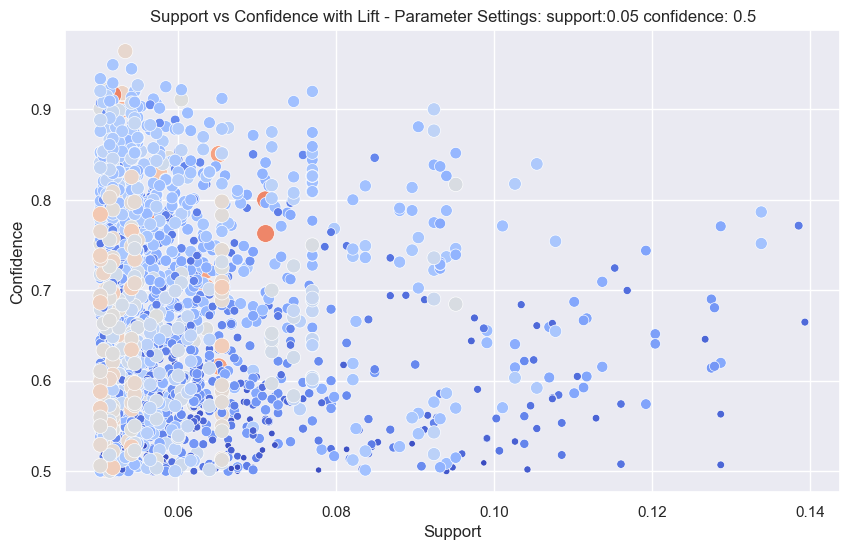

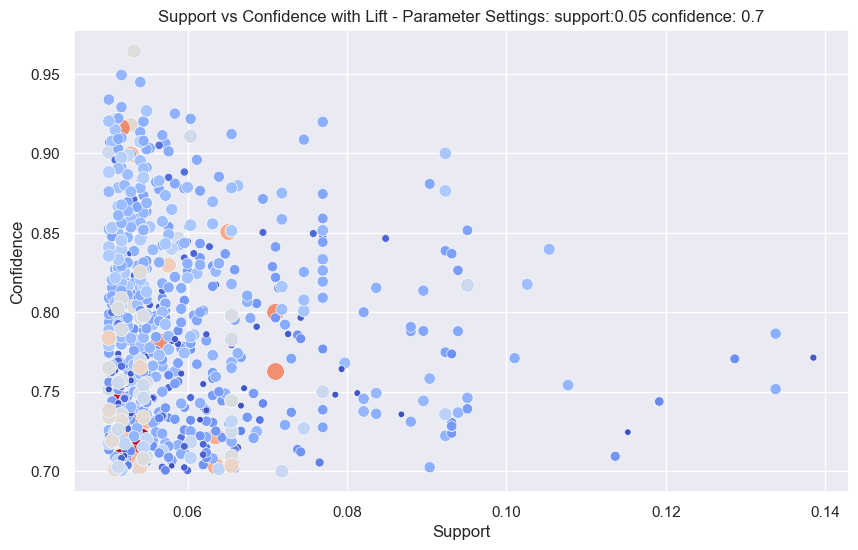

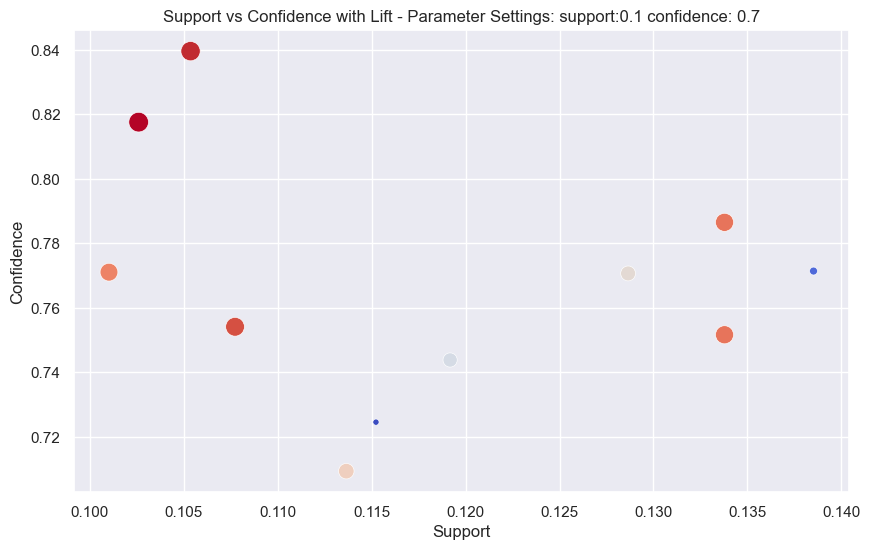

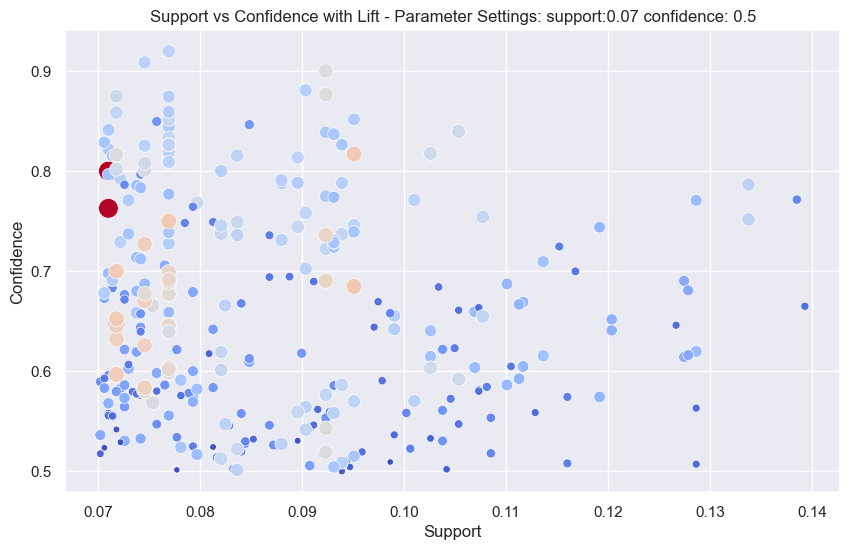

In [127]:
visualise_confid_support_lift(rules_005_05, "support:0.05 confidence: 0.5")
visualise_confid_support_lift(rules_005_07,"support:0.05 confidence: 0.7")
visualise_confid_support_lift(rules_01_07,"support:0.1 confidence: 0.7")
visualise_confid_support_lift(rules_007_05,"support:0.07 confidence: 0.5")

**Graph with Support: 0.05, Confidence: 0.5**

According to the graph, the low support and moderate confidence helped to identify a large number of association rules.
The lift (used as the hue in the graph) shows there are a lot of weak and moderate associations, and some associations are strong.

**Graph with Support: 0.05, Confidence: 0.7**

It shows that increasing the confidence filters out some rules, but in general, the number of rules remains high due to the low support threshold.
By increasing the confidence, we got rid of the rules that have reliability lower than 0.7.

**Graph with Support: 0.1, Confidence: 0.7**

In this case, increasing the support while keeping the confidence level at 0.7, we have created a more strict rule which filtered out most of the rules, keeping only the top frequent ones.
For this dataset, such a setting gets rid of most of the association rules, which is not useful.
Also, increasing the confidence level does not have a dramatic effect on the top list as it only filters out the rules on the bottom.
This means setting the confidence level that interests us and playing with support can help uncover a new set of rules which might help to uncover hidden patterns of association rules.


**The last graph with Support: 0.06, Confidence: 0.7** and the Top Singular and Top Multi proves that increasing the support helps to get more frequent association rules and uncover other rules patterns.